In [1]:
import sqlite3
import pandas as pd

# Ruta al archivo .db
database = sqlite3.connect(r'C:\Users\macar\Documents\Maestria Data Science - Austral\2 Año\LABORATORIO 3\base_relacional.db')  

# Ver las tablas disponibles en la base
consulta_tablas = "SELECT name FROM sqlite_master WHERE type='table';"
tablas = pd.read_sql(consulta_tablas, database)
print("Tablas en la base de datos:")
print(tablas)


Tablas en la base de datos:
              name
0  sqlite_sequence
1        productos
2           stocks
3           sellin


In [2]:
def ejecutar_consulta(query, db_path=r'C:\Users\macar\Documents\Maestria Data Science - Austral\2 Año\LABORATORIO 3\base_relacional.db'):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

query = """
SELECT customer_id, product_id, periodo, tn
FROM sellin
"""
ventas_df = ejecutar_consulta(query)

pivot_df = ventas_df.pivot_table(
    index=['customer_id', 'product_id'],
    columns='periodo',
    values='tn'
).reset_index()

pivot_df.columns.name = None
pivot_df = pivot_df.rename_axis(None, axis=1)

pivot_df.head()

,customer_id,product_id,201701,201702,201703,201704,201705,201706,201707,201708,...,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912
0,10001,20001,99.43861,198.84365,92.46537,13.29728,101.00563,128.04792,101.20711,43.33930,...,130.54927,364.37071,439.90647,65.92436,144.78714,33.63991,109.05244,176.02980,236.65556,180.21938
1,10001,20002,87.64856,66.08396,75.09182,49.51494,122.40283,167.46470,156.15120,18.15133,...,220.19153,155.81927,264.55349,151.12081,103.12062,148.91108,213.36148,430.90803,547.87849,334.03714
2,10001,20003,100.21284,126.97776,114.52896,37.34640,76.66386,108.30456,87.14160,43.57080,...,125.49948,86.54509,74.71874,78.79703,105.81480,121.06458,101.61982,196.18531,135.69192,137.98717
3,10001,20004,21.73954,29.76246,42.54996,9.31694,8.33349,10.92153,15.01063,12.42259,...,25.94769,17.84712,27.99741,34.26047,16.04585,8.33349,20.57492,37.88891,27.58851,12.94020
4,10001,20005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.66966,1.72238,4.25654,3.20851,5.41195,2.51269,5.66966,7.98907,11.01719,7.66693


#### Verificar valores nulos y reemplazar NaN por ceros.

In [4]:
# Filtrar solo las columnas de períodos (datos de tn)
periodos = pivot_df.columns[2:]
datos_series = pivot_df[periodos]

# Reemplazar NaN por 0 solo en las columnas de datos
pivot_df[periodos] = pivot_df[periodos].fillna(0)

## Modelo SARIMAX (prueba)

#### Diferenciación

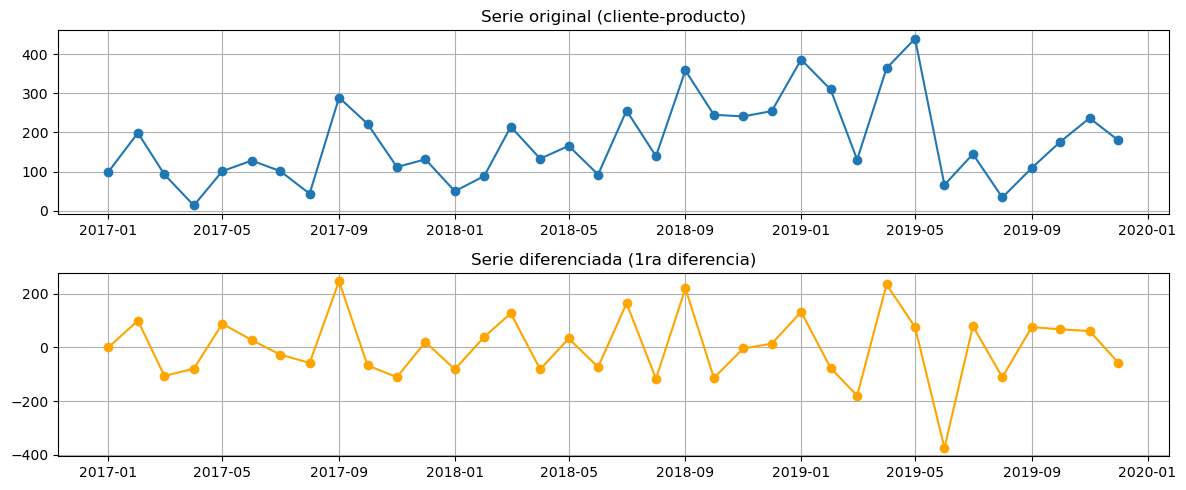

In [21]:
# 2. Filtrar series con al menos 4 períodos con ventas positivas (>0)
ventas_positivas = (pivot_df[periodos] > 0).sum(axis=1)
pivot_filtrado = pivot_df[ventas_positivas >= 4].copy()

# 3. Aplicar diferenciación simple a cada serie (por columnas de período)
pivot_filtrado_diff = pivot_filtrado.copy()
pivot_filtrado_diff[periodos] = pivot_filtrado[periodos].diff(axis=1).fillna(0)

# 4. Extraer una serie individual para graficar: la primera del filtrado
import matplotlib.pyplot as plt

serie_original = pivot_filtrado.iloc[0, 2:]
serie_diff = pivot_filtrado_diff.iloc[0, 2:]

# Convertir períodos a fechas reales
fechas = pd.to_datetime(serie_original.index.astype(str), format="%Y%m")

# Graficar original y diferenciada
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(fechas, serie_original.values, marker='o')
plt.title("Serie original (cliente-producto)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(fechas, serie_diff.values, marker='o', color='orange')
plt.title("Serie diferenciada (1ra diferencia)")
plt.grid(True)

plt.tight_layout()
plt.show()



### Implementación del Modelo SARIMAX

c:\Users\macar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\macar\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\macar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


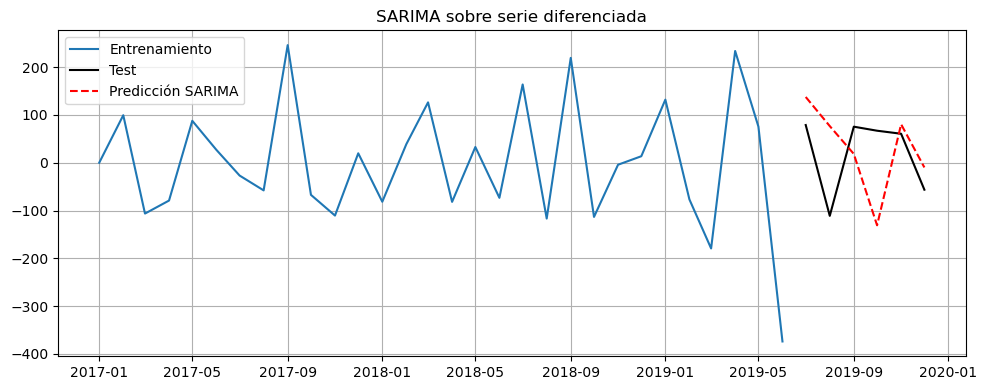

RMSE sobre test: 118.10
Error porcentual promedio: 121.61%


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Trabajamos con la serie diferenciada
serie_modelo = serie_diff.copy()
serie_modelo.index = fechas  # aseguramos índice de fechas para el modelo

# Separar entrenamiento y test (por ejemplo: últimos 6 meses como test)
train = serie_modelo.iloc[:-6]
test = serie_modelo.iloc[-6:]

# Ajustar modelo SARIMA
modelo = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))  # estacionalidad de 4 períodos
resultado = modelo.fit(disp=False)

# Predecir sobre el período de test
pred = resultado.predict(start=test.index[0], end=test.index[-1])

# Gráfico
plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(pred.index, pred, label='Predicción SARIMA', color='red', linestyle='--')
plt.title("SARIMA sobre serie diferenciada")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcular error de predicción
rmse = np.sqrt(mean_squared_error(test, pred))
print(f"RMSE sobre test: {rmse:.2f}")

error_pct = np.mean(np.abs((test - pred) / test)) * 100
print(f"Error porcentual promedio: {error_pct:.2f}%")

### Conclusión:

Aunque se aplicó un modelo SARIMAX como primer intento tradicional, el error porcentual extremadamente alto demuestra que este enfoque no logra capturar adecuadamente el comportamiento de la serie. 
Se justifica abandonar este enfoque y pasar a uno más flexible y moderno como LightGBM o XGBoost, donde se puedan usar múltiples variables explicativas. (feature engineering)
